# 1.1. Convolution

The remarkable success of modern deep learning models began with 
**Convolutional Neural Networks (CNNs)**. In this notebook, we will introduce the fundamental 
concept of the convolution operation, which is at the core of CNNs.

In mathematical terms, the **discrete convolution** of two functions, $ f $ and $ g $, is expressed as:

$
(f * g)[n] = \sum_{m=-M}^{M} f[n-m] g[m]
$

Here, $ M $ represents the size of the window that slides across the input, applying the operation at each step. This sliding action is why convolution is often referred to as a **sliding window** operation. Simply put, convolution involves calculating a weighted sum of neighbouring elements within a signal or image.

Convolution is a widely-used technique in **signal processing** and **image analysis**. For instance, classical image processing algorithms often rely on this operation to filter or transform images. Given its importance, convolution is implemented in many popular programming libraries, making it easier to apply in practice.

<a href="https://en.wikipedia.org/wiki/Convolution#Discrete_convolution" target="_blank">
    <img src="https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif" />
</a>

To visualise the process, think of convolution as involving three matrices:

1. **Input**: The original data or signal (e.g., an image).
2. **Kernel (Filter)**: A smaller matrix, defining the neighbouring weights, that is slid over the input.
3. **Output**: The resulting matrix after applying the kernel to the input.

As the kernel moves across the input, at each position, it computes a weighted sum of the values under it, which is then placed in the corresponding position of the output matrix. This process repeats until every element of the input has been covered.

In this notebook, we will explore different ways of implementing the convolution operation using common libraries. By the end of this section, you will have a hands-on understanding of how convolution works, along with the practical details required to apply it in various contexts.


## 0. Preparation

Before we dive into the main content of this notebook, let's start by preparing all the necessary materials.

### Required Packages

We will need several libraries to implement this tutorial, each serving a specific purpose:

- **[numpy](https://numpy.org/):** The main package for scientific computing in Python. It's commonly imported with the alias `np` to simplify its use in code.
- **[matplotlib](https://matplotlib.org/):** A library for plotting graphs and visualising data in Python.
- **[torch](https://pytorch.org/docs/stable/index.html):** A deep learning framework that helps us define neural networks, manage datasets, optimise loss functions, and more.
- **[cv2](https://docs.opencv.org/4.x/index.html) (OpenCV):** A widely-used computer vision library for image processing and computer vision tasks.
- **[skimage](https://scikit-image.org/):** A collection of algorithms for image processing, ideal for various transformation and analysis tasks.

Now, let's go ahead and import these packages:

In [1]:
# Importing the necessary packages/libraries
import numpy as np  # The "as" keyword allows us to give the package a shorthand name
from matplotlib import pyplot as plt  # For plotting graphs
import cv2  # OpenCV for computer vision tasks
import skimage  # For image processing
import torch  # PyTorch for deep learning

### Input Image

In this section, we will work with images to observe the effect of convolution on them. We begin by loading two images from URLs using the `skimage.io.imread` function. After loading the images, we will visualise them using routines from the `matplotlib` library.

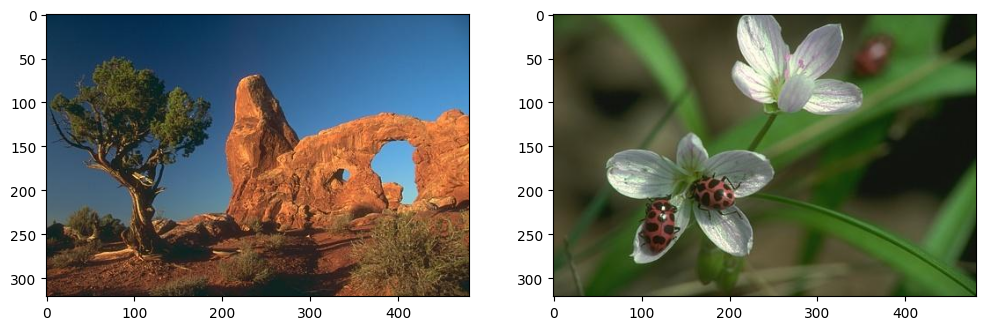

In [2]:
# URLs of the images we will load
urls = [
    'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/295087.jpg',
    'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/35008.jpg'
]

# Load the images using list comprehension
imgs = [skimage.io.imread(url) for url in urls]

# Visualise the two images side by side
fig = plt.figure(figsize=(12, 4))  # Create a figure with a custom size
for img_ind, img in enumerate(imgs):
    ax = fig.add_subplot(1, 2, img_ind + 1)  # Add subplots for each image
    ax.imshow(img)  # Display the image

Next, let’s check the **shape** and **data type** of the images to better understand their structure.

In [3]:
# Print the size (shape) and data type of the first image
print("Image size:", imgs[0].shape)
print("Image type:", imgs[0].dtype)

Image size: (321, 481, 3)
Image type: uint8


In most cases:
- **RGB images** have three dimensions: `(height, width, channels=3)`, where the third dimension represents the Red, Green, and Blue (RGB) channels.
- **Greyscale images** only have two dimensions: `(height, width)`.

In this example, the images have a height of $h = 321$ and a width of $w = 481$.

Most images, including the ones we are working with, are stored in the **unsigned integer format** `uint8`, meaning pixel values range from 0 to 255

### Visualising RGB Channels

To gain a better understanding of how images are represented, let’s plot each individual RGB channel (Red, Green, and Blue) separately. This will allow us to see the contribution of each colour channel to the overall image.

We will define a function to visualise the three channels of an image.

In [4]:
# Function to plot the three colour channels separately
def plot_3channels(img):
    channel_names = ['Red', 'Green', 'Blue']  # Labels for each channel
    fig = plt.figure(figsize=(16, 4))  # Create a wide figure
    for i in range(img.shape[2]):  # Loop through the three channels
        ax = fig.add_subplot(1, 3, i + 1)  # Create three subplots
        ax.imshow(img[..., i], cmap='gray')  # Display each channel as a greyscale image
        ax.axis('off')  # Turn off axes for clarity
        ax.set_title(channel_names[i])  # Set the title to the channel's name

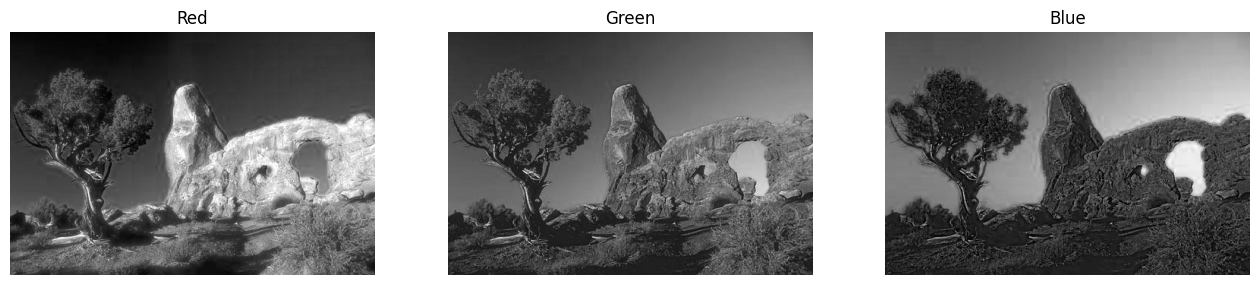

In [5]:
# showing the first image
plot_3channels(imgs[0])

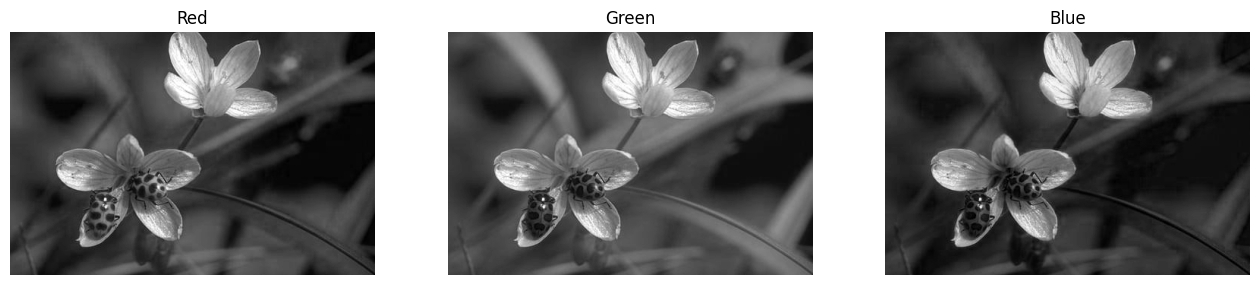

In [6]:
# showing the second image
plot_3channels(imgs[1])

## 1. OpenCV

Now that we have loaded our input images, we will use the **OpenCV** library (`cv2`) to explore the convolution operation. In particular, we will use the `filter2D` function, which performs convolution, to investigate two key applications of convolution in image processing: **edge detection** and **image blurring**.

### Edge Detection

First, we will design a simple **edge detection kernel** that is sensitive to vertical edges. A kernel (or filter) is typically a small matrix used to detect certain features in an image, such as edges or textures. These small matrices make convolution computationally efficient and widely used in image processing.

In this example, we define a **3x3 edge detection kernel**. The matrix has opposite (antagonistic) signs in the first and third columns, making it sensitive to vertical edges in the image.

In [7]:
# Defining a simple 3x3 edge detection kernel
edge_kernel = np.array(
    [
        [1, 0, -1],  # Detects vertical changes in pixel intensity
        [1, 0, -1],  # Rows are identical, looking for vertical edges
        [1, 0, -1]
    ]
)

# Printing the kernel to understand its structure
print(edge_kernel)

[[ 1  0 -1]
 [ 1  0 -1]
 [ 1  0 -1]]


Here:
- Positive values (`1`) on the left and negative values (`-1`) on the right help detect changes in pixel intensity from left to right.
- When this kernel slides over the image, it highlights vertical edges by calculating the difference in intensity between neighbouring pixels.

Next, we apply the `cv2.filter2D` function, which performs convolution, to each image using the edge detection kernel.

In [8]:
# Applying the edge detection kernel to each image using OpenCV's filter2D function
edge_imgs = [cv2.filter2D(img.copy(), ddepth=-1, kernel=edge_kernel) for img in imgs]

In this code:
- **`filter2D()`**: This function convolves the image with the given kernel. The parameter `ddepth=-1` ensures the output image has the same depth (or data type) as the input image.
- We apply the edge detection filter to both images and store the results in `edge_imgs`.

Let’s now visualise the edges detected in both images. 

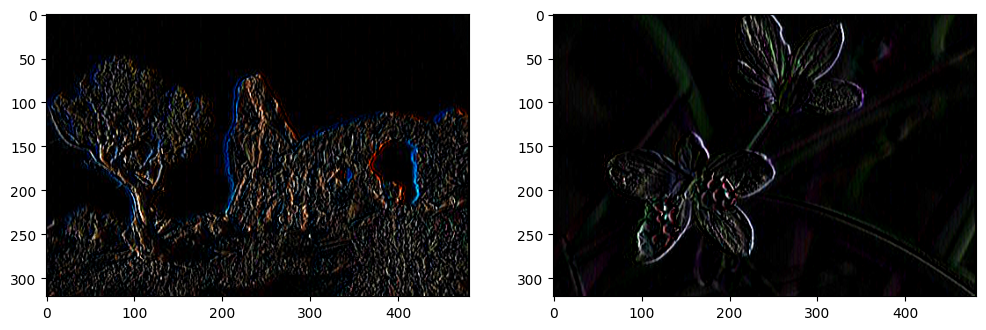

In [9]:
# Visualising the edge-detected images
fig = plt.figure(figsize=(12, 4))  # Create a figure for displaying images
for img_ind, img in enumerate(edge_imgs):
    ax = fig.add_subplot(1, 2, img_ind + 1)  # Add a subplot for each image
    ax.imshow(img)  # Display the edge-detected image

The output may look distorted because the edges in the RGB colour channels may not align perfectly. To better understand the results, we can display the detected edges for each colour channel separately (Red, Green, and Blue).

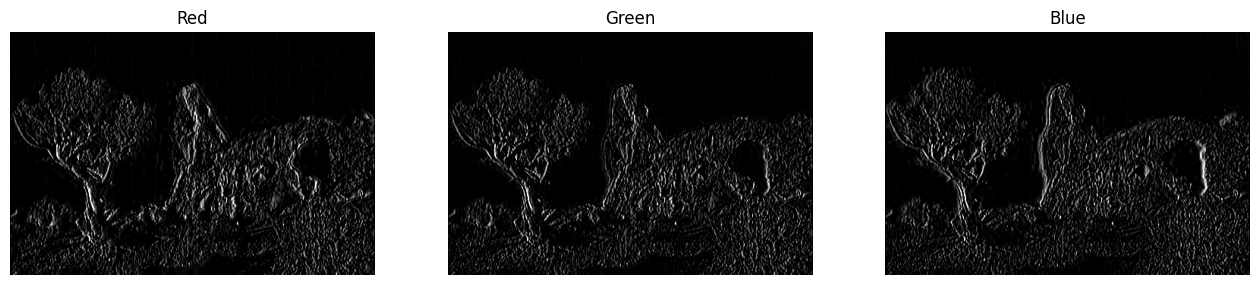

In [10]:
# plot the edges in the first image
plot_3channels(edge_imgs[0])

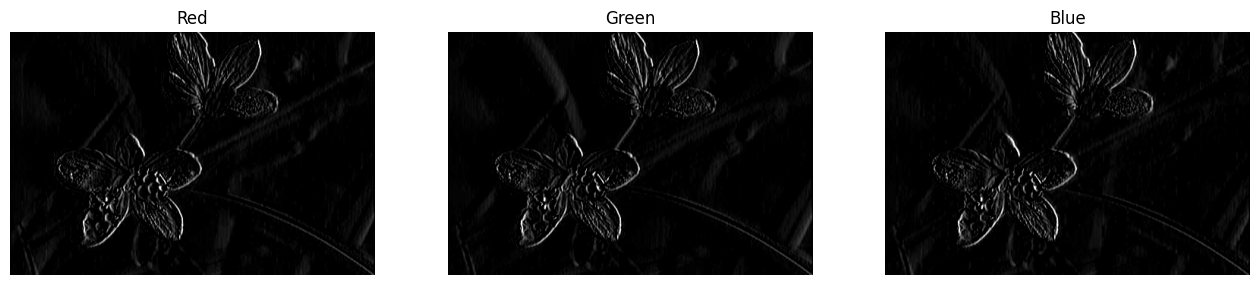

In [11]:
# plot the edges in the second image
plot_3channels(edge_imgs[1])

**Question:** What happens if we increase the size of the kernel (e.g., from 3x3 to 5x5 or larger)?

You can experiment with different kernel sizes by modifying the `edge_kernel` matrix. Larger kernels will affect a larger neighbourhood of pixels, which might result in different edges.

### Image Blurring

To blur an image, we can use a convolution operation with an "averaging" kernel. This kernel smooths the image by averaging the pixel values within a sliding window, reducing sharp edges and fine details.

We will start by creating a **5x5 averaging kernel**. Each element in this kernel has an equal weight, meaning that the convolution will compute the mean value of the pixel intensities within the window it slides over.

In [12]:
# Define the size of the kernel (5x5)
kernel_size = 5

# Create the averaging kernel with equal weights (normalised by the total number of elements)
avg_kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)

# Print the kernel to understand its structure
print(avg_kernel)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


In the code above:
- **`np.ones((kernel_size, kernel_size))`** creates a matrix where all values are `1`.
- We then divide each element by `kernel_size ** 2` (in this case, 25) to normalise the values, ensuring the sum of the kernel elements is `1`. This ensures that the average of the pixel values in the window is computed.

Now, we will apply this blurring kernel to our input images using the same `cv2.filter2D` function as before. This will smooth out details and make the images appear less sharp.

In [13]:
# Apply the blurring kernel to each image using OpenCV's filter2D function
blurred_imgs = [cv2.filter2D(img.copy(), ddepth=-1, kernel=avg_kernel) for img in imgs]

- As with edge detection, **`filter2D()`** performs convolution. Here, the kernel computes the average of the pixel values in a 5x5 neighbourhood for each pixel, producing a blurred version of the image.

Let’s visualise the results to observe how the images have been blurred.

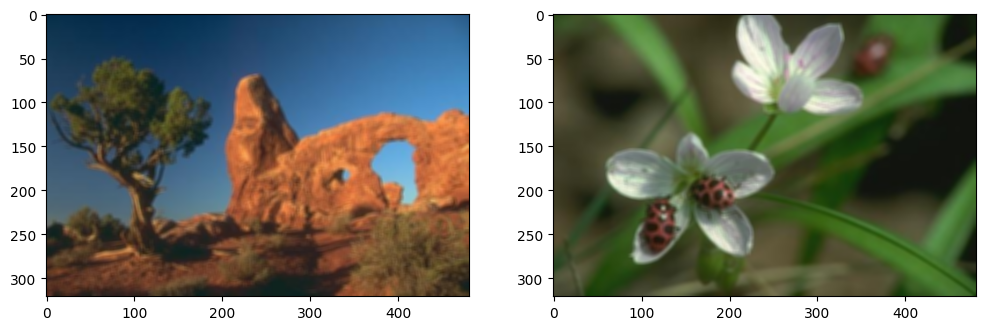

In [14]:
# Visualising the blurred images
fig = plt.figure(figsize=(12, 4))  # Create a figure to display the images
for img_ind, img in enumerate(blurred_imgs):
    ax = fig.add_subplot(1, 2, img_ind + 1)  # Add subplots for each image
    ax.imshow(img)  # Display the blurred image

In this visualisation:
- The images will appear smoother and less sharp compared to the original versions, as the averaging kernel reduces the intensity of edges and fine details.

These two simple examples—**edge detection** and **image blurring**—demonstrate the power of the convolution operation. Despite being a basic operation, convolution is foundational in many image processing tasks. CNNs leverage this operation by combining thousands of convolutional layers to detect complex patterns in data, ultimately forming powerful models for tasks such as image recognition and classification.

In the next section, we will explore how convolution operations are implemented in the **PyTorch** library, which we will be using throughout this course for deep learning applications.

## 2. PyTorch

In this section, we will explore how to perform similar convolution operations using **PyTorch**. While PyTorch functions are designed to be used within neural networks, here we will use them on single images to help you better understand the fundamental operations. In this tutorial, we will focus on **edge detection**, but you can try image blurring on your own as an exercise.

### Working with Tensors

PyTorch uses a different format for images compared to libraries like OpenCV. Specifically:
- The image type should be `float` (not `uint8`).
- The **channel dimension** (representing colour channels) must come before the **spatial dimensions** (width and height), i.e., the shape should be `(3, h, w)` for an RGB image.
- PyTorch functions typically expect 4D tensors, where the first dimension corresponds to a batch of images. In our case, since we have two images, the shape will be `(b, 3, h, w)` with `b=2`.

Let's begin by converting our images to the format expected by PyTorch.

In [47]:
# Convert the images from uint8 (0-255) to float32 and scale to [0, 1]
torch_tensors = [torch.from_numpy(img.astype('float32')) / 255 for img in imgs]

# Permute the dimensions to move the colour channels (RGB) first
torch_tensors = [torch.permute(torch_tensor, (2, 0, 1)) for torch_tensor in torch_tensors]

# Stack both images into one 4D tensor (batch_size, channels, height, width)
torch_tensors = torch.stack(torch_tensors, dim=0)

# Check the size of the resulting tensor
print("Tensor size:", torch_tensors.shape)

Tensor size: torch.Size([2, 3, 321, 481])


- **`torch.from_numpy()`** converts the NumPy array to a PyTorch tensor.
- **`torch.permute()`** rearranges the dimensions to put the colour channels first.
- **`torch.stack()`** combines both images into a single tensor with a batch dimension.

### Edge Detection with PyTorch

We will now apply a convolution operation in PyTorch using the `torch.nn.Conv2d` function. This function will convolve the input tensor with a kernel, similar to what we did in OpenCV.

In [64]:
# Create a Conv2d layer with 3 input channels (RGB) and 1 output channel (for edges)
torch_conv = torch.nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(3, 3), bias=False)

# Disable gradient computation since we're not training a model
torch_conv.weight.requires_grad = False

# Print the initial random weights of the kernel
print(torch_conv.weight)
print(torch_conv.weight.shape)

Parameter containing:
tensor([[[[-0.1393,  0.1269,  0.1215],
          [ 0.0989, -0.1230, -0.1475],
          [ 0.0788, -0.1871, -0.1472]],

         [[ 0.0840, -0.1888, -0.0002],
          [ 0.1656, -0.0563, -0.1842],
          [ 0.1522, -0.0847,  0.0265]],

         [[ 0.1698,  0.1811, -0.1898],
          [ 0.1823,  0.0958, -0.0037],
          [-0.1371,  0.1908, -0.0690]]]])
torch.Size([1, 3, 3, 3])


In the code above:
- **`torch.nn.Conv2d()`** creates a convolution layer. We specify:
  - `in_channels=3`: The number of input channels (RGB).
  - `out_channels=1`: We want to produce a single channel (edge detection).
  - `kernel_size=(3, 3)`: The size of the kernel.
- **`requires_grad=False`** ensures the weights won't be updated, as we’re not training a network.

The initial weights of the kernel we created above are random. We will replace them with the **edge detection kernel** we used earlier.

In [65]:
# Fill the convolution kernel with the predefined edge detection kernel
torch_conv.weight[0] = torch.from_numpy(np.stack([edge_kernel] * 3))

# Print the updated kernel to verify the change
print(torch_conv.weight)

Parameter containing:
tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]],

         [[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]],

         [[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])


- **`torch.from_numpy()`** converts the edge kernel to a PyTorch tensor.
- **`np.stack()`** replicates the edge kernel across all three colour channels (R, G, B).

Now, we can apply the convolution operation to detect edges in the images.

In [66]:
# Apply the convolution function to the tensor containing the images
torch_edges = torch_conv(torch_tensors)

# Print the shape of the output tensor
print(torch_edges.shape)

torch.Size([2, 1, 319, 479])


- The output tensor will have the shape `(2, 1, W, H)`, where:
  - `2` corresponds to the two input images.
  - `1` is the number of output channels (edges).
  - `W` and `H` are the width and height of the resulting images.

**Question**: Why is the output's width and height smaller than the input's original dimensions ($321 \times 481$)?

### Visualise Output Tensors

To visualise the results, we will convert the PyTorch tensor back to NumPy and display the images.

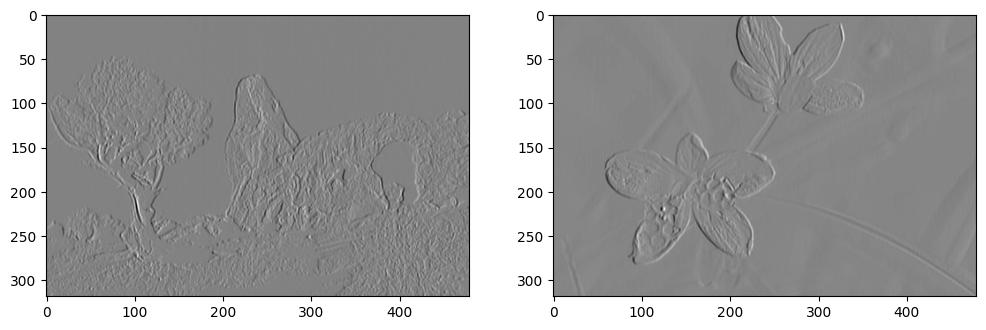

In [103]:
# Convert the tensor back to NumPy for visualisation
torch_edges_np = torch_edges.detach().numpy()  # detach from the computational graph
torch_edges_np = np.transpose(torch_edges_np, (0, 2, 3, 1))  # Rearrange dimensions for plotting

# Visualising the edge-detected images
fig = plt.figure(figsize=(12, 4))
for img_ind, img in enumerate(torch_edges_np):
    ax = fig.add_subplot(1, 2, img_ind + 1)
    ax.imshow(img, cmap='gray')  # Display the edges in grayscale

- **`torch.detach()`** detaches the tensor from the computation graph, allowing us to convert it to NumPy without gradients.
- **`np.transpose()`** reorders the dimensions to make it compatible for plotting with `matplotlib`.

**Question**: Why do the results look different from what we obtained using OpenCV?

## 3. Kernel Size in Convolutions

Convolutional kernels typically have an odd-sized window. This makes it easier to centre the kernel over each pixel in the input image during the convolution process. The size of the kernel can be specified for each dimension independently by passing a `tuple` to the `kernel_size` argument.

For example:
- `kernel_size=(3, 3)` defines a square window of 3 rows and 3 columns.
- `kernel_size=(11, 3)` defines a rectangular window spanning 11 rows and 3 columns.
- `kernel_size=(5, 1)` applies convolution only along the rows.

As the kernel size increases, the computational cost also increases. This is because the number of computations needed for the convolution grows **quadratically** with the kernel size. For instance, if we increase the kernel size from `3x3` to `5x5`, the number of calculations increases by a factor of 2.25 (since $5^2 / 3^2 = 2.25$). Critically, this increase in computational time occurs at every pixel. This can significantly impact both the time and memory required to perform the operation, especially on large images.

### $1 \times 1$ Convolution

A **$1 \times 1$ convolution** does not perform any spatial convolution. Instead, it only convolves across the depth (i.e., the colour channels). This is useful for increasing or decreasing the number of channels without changing the image's spatial resolution. It’s commonly used in deep learning to adjust the number of feature maps.

## 4. Padding in Convolution

When applying convolution, an issue arises at the **border pixels** because part of the convolution kernel may fall outside the input image. To handle this, we use **padding**, which adds extra pixels around the edges of the image. There are several types of padding:
- **'constant'**: Pads with a constant value (e.g., zeros).
- **'reflect'**: Reflects the edge of the image.
- **'replicate'**: Replicates the border pixel values.
- **'circular'**: Wraps the image in a circular manner.

If we want the output image to have the same size as the input, we need to add padding of size $\frac{kernel\_size}{2}$ (rounded down). For example, for a `3x3` kernel, we add `padding=1` to ensure the output dimensions match the input dimensions.

Here’s an example of applying convolution with padding:

In [119]:
# Create a Conv2D layer with padding to maintain the same output size as the input
torch_conv_pad = torch.nn.Conv2d(
    in_channels=3, out_channels=1, kernel_size=(3, 3), bias=False, padding=1
)

# Disable gradient computation since we're not training a model
torch_conv_pad.weight.requires_grad = False

# Fill the convolution kernel with the predefined edge detection kernel
torch_conv_pad.weight[0] = torch.from_numpy(np.stack([edge_kernel] * 3))

# Apply the convolution to the image tensor
torch_edges_pad = torch_conv_pad(torch_tensors)

# Print the shape of the output tensor
print(torch_edges_pad.shape)

torch.Size([2, 1, 321, 481])


- **`padding=1`** adds one layer of padding around the image, allowing the convolution to include the border pixels.

## 5. Downsampling

One common use of convolution is to **downsample** the input image, reducing its spatial resolution. One way to achieve this is by **not using padding**. When no padding is applied, the output size is reduced by $\frac{kernel\_size}{2} + 1$ because the convolution cannot process the border pixels.

### Stride

Another way to downsample the input is by using the **stride** parameter in the convolution operation. **Stride** refers to the number of pixels skipped during the convolution process. For instance, if `stride=2`, the convolution jumps every other pixel, effectively downsampling the image by a factor of two. 

The stride can also be set independently for each dimension, much like the kernel size. For example:
- **`stride=2`** will downsample both dimensions by a factor of two.
- **`stride=(2, 1)`** will downsample only the rows, while the columns remain unaffected.

Here’s an example of applying convolution with `stride=2` to downsample the image:


In [118]:
# Apply convolution with stride=2 to downsample both dimensions
torch_conv_stride = torch.nn.Conv2d(
    in_channels=3, out_channels=1, kernel_size=(3, 3), bias=False, padding=1, stride=2
)

# Disable gradient computation since we're not training a model
torch_conv_stride.weight.requires_grad = False

# Fill the convolution kernel with the predefined edge detection kernel
torch_conv_stride.weight[0] = torch.from_numpy(np.stack([edge_kernel] * 3))

# Apply the convolution to the image tensor
out_conv_stride = torch_conv_stride(torch_tensors)

# Print the shape of the output tensor
print(out_conv_stride.shape)

torch.Size([2, 1, 161, 241])


- In this case, the output will have half the resolution of the input in both the width and height due to `stride=2`.

Let’s see how we can downsample **only the rows** by setting `stride=(2, 1)`:

In [117]:
# Apply convolution with stride=(2, 1) to downsample only the rows
torch_conv_stride = torch.nn.Conv2d(
    in_channels=3, out_channels=1, kernel_size=(3, 3), bias=False, padding=1, stride=(2, 1)
)

# Disable gradient computation since we're not training a model
torch_conv_stride.weight.requires_grad = False

# Fill the convolution kernel with the predefined edge detection kernel
torch_conv_stride.weight[0] = torch.from_numpy(np.stack([edge_kernel] * 3))

# Apply the convolution to the image tensor
out_conv_stride = torch_conv_stride(torch_tensors)

# Print the shape of the output tensor
print(out_conv_stride.shape)

torch.Size([2, 1, 161, 481])


- Here, `stride=(2, 1)` means we downsample only the rows by a factor of two, while the columns remain at the same resolution.

## 6. Dilation

A useful way to expand the **receptive field** of a convolutional layer without significantly increasing computational cost is by using the `dilation` parameter in the `Conv2d` function. Known as the **à trous algorithm** (meaning "with holes"), `dilation` adjusts the spacing between kernel elements, allowing the convolutional layer to cover a larger area of the input image. This is different from `stride`, which controls the spacing between the points where the convolution is applied.

Below is an illustration showing how dilation works by adding gaps between elements in the kernel.

<img src="https://raw.githubusercontent.com/DeepLearning-JupyterBook/deeplearning-jupyterbook.github.io/refs/heads/master/imgs/convolution_dilation.png" />

Let’s use `dilation=3` for edge detection to see how this influences the output.

In [136]:
# Create a Conv2D layer with a dilation parameter to expand the receptive field
torch_conv_dilation = torch.nn.Conv2d(
    in_channels=3, out_channels=1, kernel_size=(3, 3), bias=False, padding=3, stride=1, dilation=3
)

# Disable gradient computation as we’re not training a model
torch_conv_dilation.weight.requires_grad = False

# Fill the kernel with a predefined edge detection kernel
torch_conv_dilation.weight[0] = torch.from_numpy(np.stack([edge_kernel] * 3))

# Apply the convolution to the image tensor
out_conv_dilation = torch_conv_dilation(torch_tensors)

# Print the shape of the output tensor
print(out_conv_dilation.shape)

torch.Size([2, 1, 321, 481])


- Notice that `padding=3` is used here to ensure the output image has the same spatial resolution as the input.

Let’s visualise the edges detected with the dilated kernel.

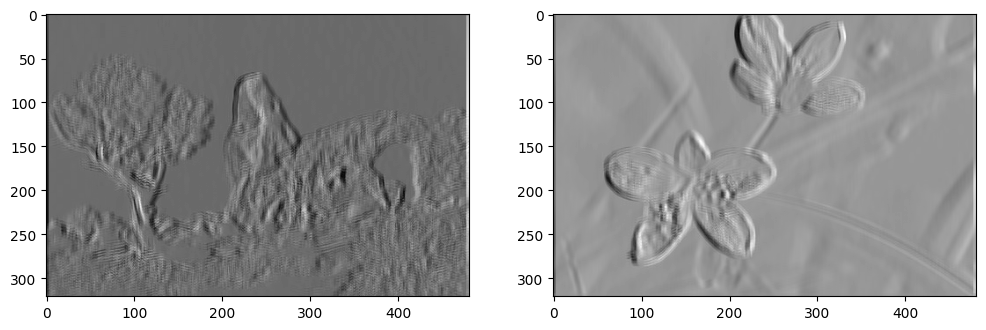

In [137]:
# Convert the tensor back to a NumPy array for visualisation
out_conv_np = out_conv_dilation.detach().numpy()  # Detach from computational graph
out_conv_np = np.transpose(out_conv_np, (0, 2, 3, 1))  # Rearrange for plotting

# Displaying the images with detected edges
fig = plt.figure(figsize=(12, 4))
for img_ind, img in enumerate(out_conv_np):
    ax = fig.add_subplot(1, 2, img_ind + 1)
    ax.imshow(img, cmap='gray')  # Show edges in grayscale

**Question**: Compare this output with the result when `dilation=1`. How has dilation affected the output edges?

## 7. Transposed convolution

The convolutional layers we have discussed so far typically reduce the spatial dimensions of the input, a process known as **downsampling**. In certain tasks, however, we may want to **increase the spatial resolution**. For example, in **semantic segmentation**, the model’s output often needs to match the spatial resolution of the input image. As convolutional layers typically downsample the input, **transposed convolution** offers a method to increase the resolution of feature maps in the network.

Though it is sometimes referred to as “deconvolution”, transposed convolution is not a true inverse operation to convolution. Instead, it uses a process that expands the spatial dimensions.

Let’s explore a basic example of transposed convolution with `ConvTranspose2d`.

In [138]:
# Create a ConvTranspose2D layer to increase spatial dimensions
torch_transpose_conv = torch.nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=(3, 3), bias=False)

# Disable gradient computation as we’re not training a model
torch_transpose_conv.weight.requires_grad = False

# Fill the kernel with the edge detection kernel
torch_transpose_conv.weight[:, 0] = torch.from_numpy(np.stack([edge_kernel] * 3))

# Apply the transposed convolution to the image tensor
out_transpose_conv = torch_transpose_conv(torch_tensors)

# Print the shape of the output tensor
print(out_transpose_conv.shape)

torch.Size([2, 1, 323, 483])


We observe that the spatial resolution of the output tensor (i.e., $323 \times 483$) is slightly larger than the input tensor ($321 \times 481$). In general, for an input size of $n_h \times n_w$ and a kernel size of $k_h \times k_w$, the output size will be $(n_h + k_h -1) \times (n_w + k_w -1)$.

Parameters like `padding` and `stride` also impact transposed convolution but in the opposite way compared to standard convolution. Here, they are applied to the output rather than the input, so setting `stride=2` increases the spatial resolution by a factor of 2.

In [139]:
# Create a ConvTranspose2D layer with stride=2 to increase spatial dimensions
torch_transpose_conv = torch.nn.ConvTranspose2d(
    in_channels=3, out_channels=1, kernel_size=(3, 3), bias=False, stride=2
)

# Disable gradient computation
torch_transpose_conv.weight.requires_grad = False

# Fill the kernel with the edge detection kernel
torch_transpose_conv.weight[:, 0] = torch.from_numpy(np.stack([edge_kernel] * 3))

# Apply the transposed convolution to the image tensor
out_transpose_conv = torch_transpose_conv(torch_tensors)

# Print the shape of the output tensor
print(out_transpose_conv.shape)

torch.Size([2, 1, 643, 963])


## Discussion

The discovery of **simple cells** in the visual cortex by Nobel Prize laureates [Hubel and Wiesel (1962)](https://pmc.ncbi.nlm.nih.gov/articles/PMC1363130/pdf/jphysiol01298-0128.pdf) marked a major breakthrough in our understanding of how the brain interprets visual information. They demonstrated that specific neurons in the **primary visual cortex (V1)** respond selectively to certain patterns within the visual field, such as edges, lines, or specific orientations. **Convolutional kernels** such as **Gabor** and **Difference-of-Gaussian (DoG)** filters effectively model these **receptive fields** and early stages of visual processing.

These biologically inspired models have not only enhanced our understanding of the visual system but have also influenced the design of **CNNs** that [mimic the process of visual recognition in the brain](https://link.springer.com/content/pdf/10.1007/BF00344251.pdf), progressively extracting hierarchical features from images. This transformation of visual information aligns with the layered processing seen in biological vision.

To see these ideas in action, an **interesting exercise** is to visualise the initial convolutional kernels in different neural network architectures, such as **AlexNet**, **ResNet**, and **Vision Transformers (ViT)**. By comparing these kernels to the receptive field models in biological vision, such as oriented Gabors or double-opponent DoG filters, we can observe how neural networks align well with the properties of the visual cortex.

***
## Exercises
Practise what we’ve covered with the following exercises:
1. Implement image blurring using `torch`.
2. Convert a colour image to greyscale by applying a convolution with `kernel_size=(1, 1)`

***
## References

1. [Animated Visualisation of Convolutional Operation](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)
2. [Transposed Convolution Explanation](https://d2l.ai/chapter_computer-vision/transposed-conv.html)